In [1]:
# %load_ext autoreload
# %autoreload 1
# %aimport utilsLoaders
# %aimport ocfeats


In [2]:
from pathlib import Path

import pandas as pd # also openpyxl for xlsx files
import numpy as np
import scipy.signal as ss
import matplotlib.pyplot as plt
import seaborn as sns

from tqdm.auto import tqdm, trange

from utilsLoaders import read_trc, read_mot
import ocfeats

# gdrive = Path('/Volumes/GoogleDrive-112026393729621442608')
gdrive = Path('/Users/psr/Library/CloudStorage/GoogleDrive-paru@stanford.edu')
datadir = gdrive / 'My Drive/NMBL Lab/OpenCap for NMD biomarkers/data'
dataset = '2023-05_dhd'

def get_trc_fpath(sid, trial):
    return datadir / dataset / f'opencap_data/{sid}/' \
        f'MarkerData/PostAugmentation/{trial}/{trial}.trc'

def get_mot_fpath(sid, trial):
    return datadir / dataset / f'opencap_data/{sid}/' \
        f'OpenSimData/Kinematics/{trial}.mot'

def get_model_fpath(sid):
    sdir = datadir / dataset / f'opencap_data/{sid}'
    return list((sdir/'OpenSimData/Model').glob('*.osim'))[0]


In [3]:
# colorblind friendly palette
from cycler import cycler
cp = ["#172A5A", "#FF7171", "#227567", "#34BAEA", "#F9D466", ]
plt.rcParams['axes.prop_cycle'] = cycler(color=cp)

# set default font
plt.rcParams['font.family'] = 'sans-serif'
plt.rcParams['font.sans-serif'] = ['Open Sans', 'Arial']

# automatically despine
plt.rcParams['axes.spines.top'] = False
plt.rcParams['axes.spines.right'] = False

# set defualt DPI
plt.rcParams['figure.dpi'] = 72


In [4]:
df_session = pd.read_excel(datadir / dataset / 'session_info.xlsx', )
df_trial = pd.read_excel(datadir / dataset / 'trial_info.xlsx')
df_part = pd.read_excel(datadir / dataset / 'participant_info.xlsx')


p011


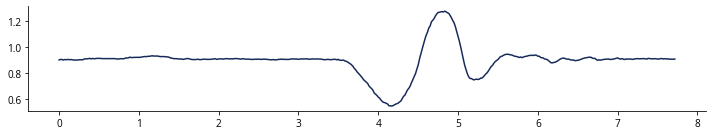

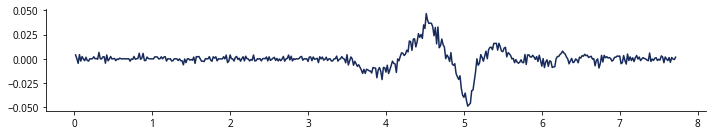

In [5]:
from numpy.linalg import norm

pid = 'p011'
# pid = 'p014'
# pid = 'p060'
# pid = 'p093'

df_temp = df_trial[df_trial.trial_clean == 'jump']
df_temp = df_temp[df_temp.pid == pid]
um = df_temp.sample(1).iloc[0]
pid, sid, trial = um[['pid', 'sid', 'trial']]
print(pid)

fps, markers, xyz = read_trc(get_trc_fpath(sid, trial))
com = xyz[:,np.argmax(markers == 'midHip'),:] # TODO uses actual CoM
max_com_vel = np.max(com[:,1])

t = np.arange(xyz.shape[0]) / fps
plt.figure(figsize=(10,2))
plt.plot(t, com[:,1])
plt.tight_layout()
plt.show()

t = np.arange(xyz.shape[0]) / fps
plt.figure(figsize=(10,2))
plt.plot(t[1:], np.diff(com[:,1]))
plt.tight_layout()
plt.show()


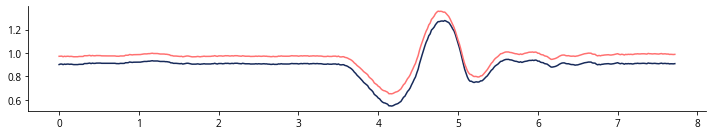

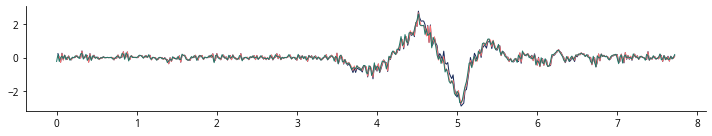

In [6]:
com_xyz = ocfeats.center_of_mass(get_model_fpath(sid), get_mot_fpath(sid, trial))
com_vel = ocfeats.center_of_mass_vel(get_model_fpath(sid), get_mot_fpath(sid, trial))

t = np.arange(xyz.shape[0]) / fps
plt.figure(figsize=(10,2))
plt.plot(t, com[:,1])
plt.plot(t, com_xyz[:,1])
plt.tight_layout()
plt.show()

t = np.arange(xyz.shape[0]) / fps
plt.figure(figsize=(10,2))
plt.plot(t[1:], np.diff(com[:,1])*fps, lw=1)
plt.plot(t[1:], np.diff(com_xyz[:,1])*fps, lw=1)
plt.plot(t, com_vel[:,1], lw=1)
plt.tight_layout()
plt.show()


In [9]:
df_temp = df_trial[df_trial.trial_clean == 'jump']
data = []
for i, row in tqdm(df_temp.iterrows(), total=df_temp.shape[0]):
    pid, sid, trial = row[['pid', 'sid', 'trial']]
    
    fps, markers, xyz = read_trc(get_trc_fpath(sid, trial))        
    com = xyz[:,np.argmax(markers == 'midHip'),:] # TODO uses actual CoM
    max_com_vel = np.max(np.diff(com[:,1])) * fps

    data.append({'pid': pid,
                 'max_com_vel': max_com_vel,
                })


  0%|          | 0/88 [00:00<?, ?it/s]

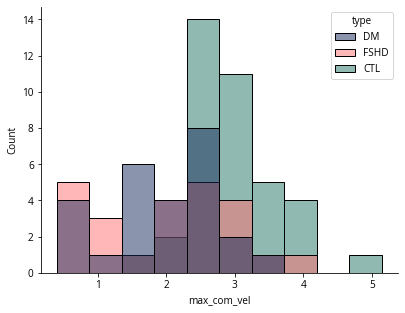

In [8]:
df_jump = pd.DataFrame(data)
df_temp = df_jump.merge(df_part[['pid', 'time_10mwt', 'type']],
                        on='pid', how='left')

sns.histplot(df_temp, x='max_com_vel', hue='type')
plt.show()
